# Shadow Finder

In [8]:
import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
# read in updated data set
data = pd.read_csv('nurve-landuse-0423.csv')
data['merge_key'] = data.index

In [20]:
# drop rows with a light value of -9998.0 
df = data[data.AMB_Lux != -9998.0]
df = df[(df.hourOfDay >= 7) & (df.hourOfDay < 18)]
df = df.reset_index()
print 'Removing failed light readings, we still retain', np.round(float(len(df))/len(data)*100,2) ,'% of the data'

Removing failed light readings, we still retain 63.87 % of the data


In [21]:
# convert time stamp to datetime object, extract hour
df['GPS_DATETIMESTAMP'] = pd.to_datetime(df['GPS_DATETIMESTAMP'])
df['hour'] = df.GPS_DATETIMESTAMP.apply(lambda x: x.hour)

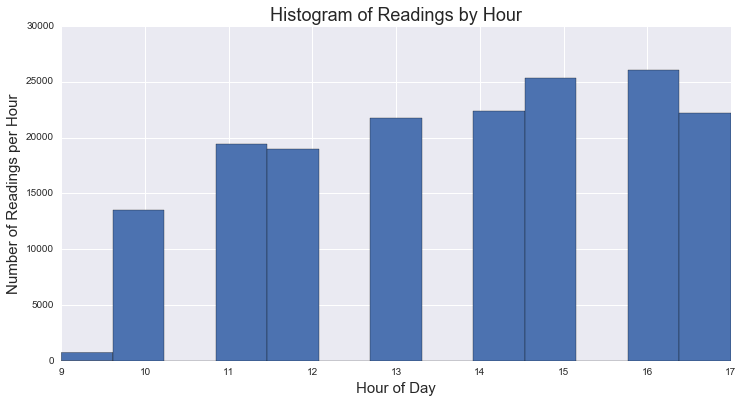

In [22]:
fig, ax = plt.subplots(figsize=(12,6))

plt.subplot(111)
plt.hist(df.hourOfDay, bins = 13)
plt.title('Histogram of Readings by Hour', fontsize=18)
plt.xlabel('Hour of Day', fontsize = 15)
plt.ylabel('Number of Readings per Hour', fontsize=15)


In [23]:
# next calculate hourly thresholds for light
df.columns

Index([u'index', u'Unnamed: 0', u'ID', u'GPS_DATETIMESTAMP', u'GPS_LAT',
       u'GPS_LON', u'GPS_Speed', u'GPS_Alt', u'GPS_Sats', u'GPS_Fix',
       u'GPS_Quality', u'AMB_Temp', u'AMB_Humd', u'AMB_Lux', u'AMB_Snd',
       u'AMB_SndMin', u'AMB_SndMax', u'AMB_SndMea', u'RDQ_AcX', u'RDQ_AcXMin',
       u'RDQ_AcXMax', u'RDQ_AcXMea', u'RDQ_AcY', u'RDQ_AcYMin', u'RDQ_AcYMax',
       u'RDQ_AcYMea', u'RDQ_AcZ', u'RDQ_AcZMin', u'RDQ_AcZMax', u'RDQ_AcZMea',
       u'sensor', u'timestamp', u'hourOfDay', u'minuteOfDay',
       u'minuteStretched', u'LU05_DESC', u'LUCODE', u'merge_key', u'hour'],
      dtype='object')

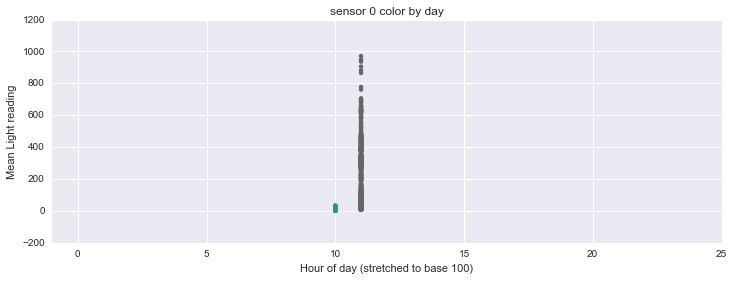

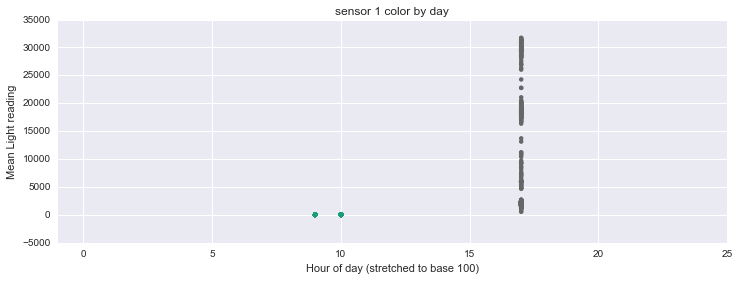

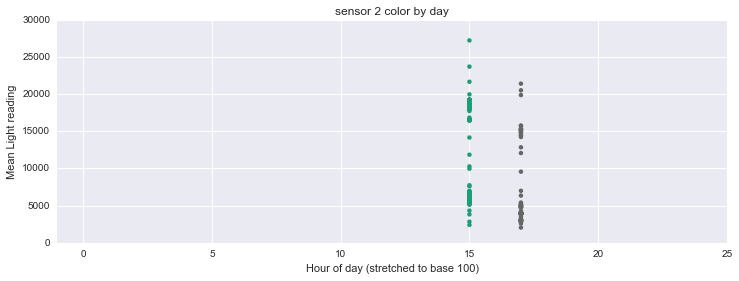

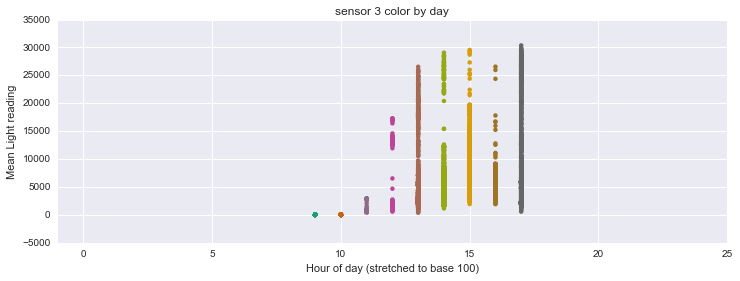

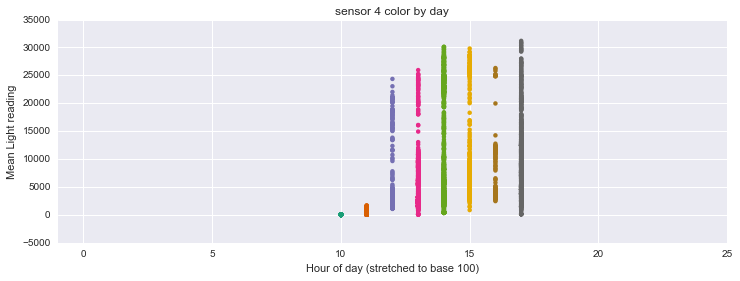

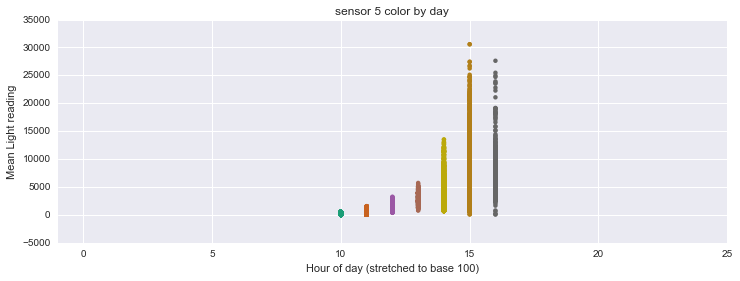

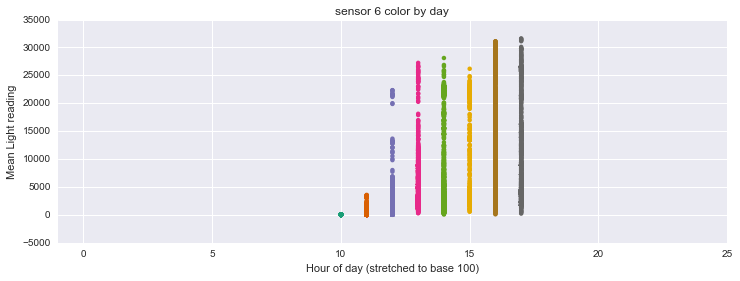

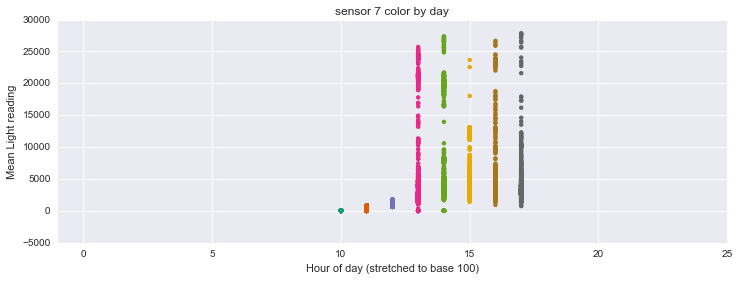

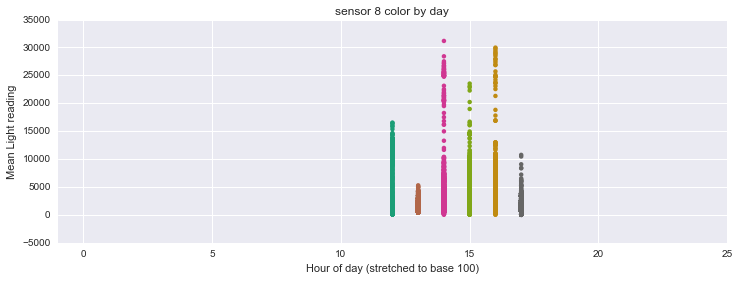

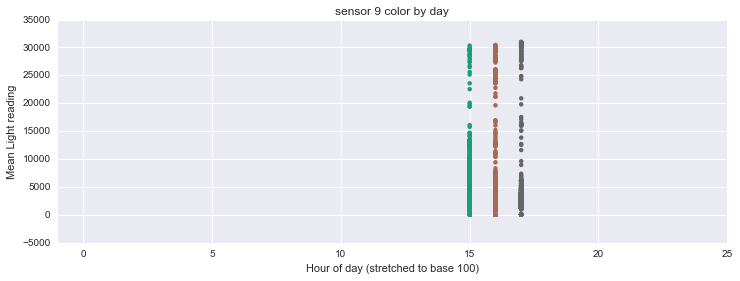

In [24]:
# plotting hourly distribution of sensor readings
for i in sorted(df.sensor.unique()):
    plt.figure(figsize=(12,4))
    plt.scatter(df.hour[df.sensor==i], df.AMB_Lux[df.sensor==i], linewidths=0, c=df.hour[df.sensor==i],
                cmap=plt.get_cmap('Dark2', len(df.hour[df.sensor==i].unique())))
    plt.xlabel('Hour of day (stretched to base 100)')
    plt.ylabel('Mean Light reading')
    plt.title('sensor {} color by day'.format(i))
    #plt.ylim(0,1000)
    plt.xlim(-1,25);

In [27]:
# calculate the shadow threshold used for the flag variable to indicate shadows or unusual darkness
# 
light_thresh = []
for i in df.sensor.unique():
    temp = df[df.sensor==i]
    light_thresh.append((i, np.percentile(temp.AMB_Lux, 10)))

In [28]:
# dataframe below holds the threshold for shadow/not shadow flag variable
# merged with complete df, but we need to break it out by hour of the day first
light_thresh = pd.DataFrame(light_thresh, columns = ['sensor','threshold'])
light_thresh

,sensor,threshold
0,0,11.0
1,1,2.0
2,2,3884.0
3,3,1955.0
4,4,20.0
5,5,6.0
6,6,6.0
7,7,35.0
8,8,519.3
9,9,1131.0


In [106]:
df['is_dark'] = 0

for s in df.sensor.unique():
    for h in df[df.sensor==s].hourOfDay.unique():
        idx = df[(df.sensor==s) & (df.hourOfDay==h)].index
        bottom10 = np.percentile(df.loc[idx,'AMB_Lux'], 10)
        idxDark = df.loc[idx, ('AMB_Lux')].apply(lambda x: True if x > bottom10 else False)
        df.loc[idx[idxDark], 'is_dark'] = 1

In [115]:
df.loc[:,('merge_key','is_dark')].to_pickle('shadow.pickle')